In [1]:
%pylab inline
import tensorflow as tf
import os
import sys
import math
import collections
import glob
import sys
import IPython
from scipy.io import wavfile
from scipy import signal
import librosa
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import time
import itertools

class Data():
    
    def __init__(self,X,y,test_size=0.33,random_state=42,stratify=None):
        
        from sklearn.model_selection import train_test_split
        
        self.X = X
        self.y = y
        self.batch_ix = 0
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( self.X, self.y, test_size=test_size, random_state=random_state,stratify=stratify)

        self.length = self.X_train.shape[0]
        self.ixs = np.arange(self.length)
        np.random.shuffle(self.ixs)
        
    def next_batch(self,batch_size):
        
        X_ = self.X_train[self.ixs[np.arange(self.batch_ix,self.batch_ix+batch_size) % self.length]]
        y_ = self.y_train[self.ixs[np.arange(self.batch_ix,self.batch_ix+batch_size) % self.length]]
        
        self.batch_ix+=batch_size
        
        if self.batch_ix > self.length:
            np.random.shuffle(self.ixs)
            
        return X_,y_
    
    def train(self):
        return  self.X_train, self.y_train
    
    def test(self):        
        return  self.X_test, self.y_test
    
class NN(object):
        
    def __init__(self,layer_sizes,activation=tf.tanh, stddev = 0.05,learning_rate=0.002):
        
        self.layer_sizes = layer_sizes
        self.Ws = []
        self.bs = []
        
        tf.reset_default_graph()

        self.x = x = tf.placeholder(tf.float32, [None, layer_sizes[0]], name='input')  # Input
        self.y_true = y_true = tf.placeholder(tf.float32, [None, layer_sizes[-1]], name='truth')  # Thruth

        # NN Config  (based on: https://github.com/m2march/CADL/blob/master/session-2/lecture-2.ipynb)

        last_output = x
        last_output_size = layer_sizes[0]

        for idx, ls in enumerate(layer_sizes[1:]):
            
            with tf.variable_scope('layer{}'.format(idx)):

                W = tf.get_variable(
                                name='W',
                                shape=[last_output_size, ls],
                                initializer=tf.random_normal_initializer(mean=0.0, stddev=stddev), dtype=tf.float32)        

                b = tf.get_variable(
                                name='b',
                                shape=[ls],
                                initializer=tf.random_normal_initializer(mean=0.0, stddev=stddev), dtype=tf.float32)

                h = tf.matmul(last_output, W) + b
                h = activation(h)

                last_output = h
                last_output_size = ls
                
                self.Ws.append(W)
                self.bs.append(b)
                
        self.y_pred = y_pred = last_output
        
        correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_true,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))
        
        self.train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
        
    def initialize(self):

        config = tf.ConfigProto( device_count = {'GPU': 0} )
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())

    def optimize(self,data,batch_size=1,n_epochs=100, print_output=True):

        accuracy_hist = []
        n_batchs = int(data.length/batch_size)
        acc_test = acc_train = 0

        for epoch_i in range(n_epochs):
            for batch_i in range(n_batchs):

                X_train,y_train = data.next_batch(batch_size)

                ts, acc_train_ = self.sess.run([self.train_step,self.accuracy], feed_dict={self.x: X_train, self.y_true: y_train})
                
            acc_train = max(acc_train,acc_train_)
            
            X_test, y_test = data.test()
            acc_test_ = self.sess.run(self.accuracy, feed_dict={self.x: X_test, self.y_true: y_test})
            acc_test = max(acc_test,acc_test_)
            
            if print_output:
                if (epoch_i+1)%10==0:
                    print('\rEpoch: {}/{} Epoch accuracy: test {}, train {}'.format(
                        epoch_i + 1, n_epochs, str(around(acc_test, 4)), str(around(acc_train,4)) ))

            accuracy_hist.append((acc_test,acc_train))

        return accuracy_hist

Populating the interactive namespace from numpy and matplotlib


In [2]:
all_dirs = [d_dir for d_dir in os.listdir('drums') if os.path.isdir(os.path.join('drums', d_dir))]
all_wavs = [os.path.join('drums', d_dir, wf)
            for d_dir in all_dirs 
            for wf in os.listdir(os.path.join('drums', d_dir)) if wf.endswith('.wav')]
print('#(**/*.wav): ', len(all_wavs))

print('Subtipos:')
drum_types_base = ['crash', 'tom', 'hat', 'snare', 'kick']
drum_types = drum_types_base + ['bass','hh']
for dt in drum_types:
    print("#(**/*{}*.wav): {}".format(dt, len([wf for wf in all_wavs if os.path.basename(wf).lower().find(dt) > 0])))

#(**/*.wav):  6750
Subtipos:
#(**/*crash*.wav): 77
#(**/*tom*.wav): 487
#(**/*hat*.wav): 290
#(**/*snare*.wav): 612
#(**/*kick*.wav): 458
#(**/*bass*.wav): 58
#(**/*hh*.wav): 154


In [3]:
metadata_list = []
raw_list = []

fs = 44100
T = 1
input_len = fs*T

for wf in all_wavs:
    try:
        sr, wav = wavfile.read(wf)
        
        name = os.path.basename(wf).lower()[:-4]

        category = 'None'
        for dt in drum_types:
            if name.find(dt) > 0:
                category = dt
                break

        metadata = {'filename':wf,
             'name':name,
             'category':category,
             'sr':sr,
             'ch': wav.shape[1] if len(wav.shape) > 1 else 1, 
             'durs':len(wav) / float(sr),
        }

        metadata_list.append(metadata)

        if category != 'None':
            x = zeros(input_len)
            len_ = min(input_len, wav.size)
            x[:len_] = wav[:len_]/2.0**15

            raw_list.append( x )            

    except Exception as e:
        print(wf,e)
    
df_meta = pd.DataFrame(metadata_list)

df_raw = pd.DataFrame(raw_list)

/usr/local/lib/python3.4/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


drums/Roland JV 1080/MaxV - Guiro.wav local variable 'data' referenced before assignment


In [4]:
df = df_meta[df_meta.category!='None'].copy()

# Categories: 

- Kick, Bass
- Hat, HH
- Tom
- Snare

In [5]:
print(df.category.value_counts())

relabel = [('bass','kick'),('hh','hat')]

for variant,org in relabel:
    df.set_value(df.category==variant,'category',org)
    
df.category.value_counts()

snare    612
tom      487
kick     458
hat      290
hh       154
crash     77
bass      51
Name: category, dtype: int64


snare    612
kick     509
tom      487
hat      444
crash     77
Name: category, dtype: int64

## Dummies

In [6]:
classes_n = len( drum_types_base )
y = pd.get_dummies(df.category)
y.head(10)

,crash,hat,kick,snare,tom
1,0,0,0,0,1
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,1,0,0
5,0,1,0,0,0
6,0,0,0,1,0
7,0,0,0,0,1
9,0,1,0,0,0
10,0,0,0,0,1
11,0,1,0,0,0


# Media y SD del dataset

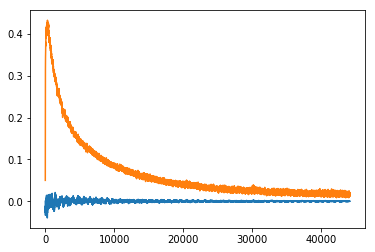

In [7]:
plot((df_raw).mean(0))
plot((df_raw).std(0));

# Features:

## - Waveform

$x_n$

## - Discrete Fourier Transform

$\displaystyle X_{k} =\sum _{n=0}^{N-1}x_{n}\cdot e^{-i2\pi kn/N} $

## - Power Spectrum (linear)

$ P_k = (X_k/N)^2$

## - Power Spectrum (dB)

$ PdB_k = 10 log_{10}(P_k)$

## - Spectrogram

$ \displaystyle STFT(m,k) = \sum _{n=0 }^{N-1 }x_n w_{n-m} e^{-i2\pi kn/N}$

## - Mel Spectrogram (dB)

![](https://labrosa.ee.columbia.edu/doc/HTKBook21/img165.gif)

$MEL = MEL\_FB \cdot STFT$

## - MFCC

$X_k = \frac{1}{2} x_0 +
 \sum_{n=1}^{N-1} x_n \cos \left[\frac{\pi}{N} n \left(k+\frac{1}{2}\right) \right] \quad \quad k = 0, \dots, N-1.$
 
![](https://librosa.github.io/librosa/_images/librosa-filters-dct-1.png)

$ MFCC = DCT\_BASIS \cdot MEL $

In [8]:
def normalize(X,m=0,M=1):
    return (X-X.min())/(X.max()-X.min())*(M-m)+m

In [9]:
do_features = False
if do_features:

    save('waveform.npy',df_raw.values)

    S = abs(fft.fft(df_raw.values,axis=1)[:,:input_len//2])**2
    save('spectrum.npy',normalize(S,-1,1).astype(float32))

    S_ = 10*log10(S/1e-10).clip(0)
    save('spectrum_db.npy',normalize(S_,-1,1).astype(float32))

In [10]:
if do_features:

    X = []
    for i, r in df_raw.iterrows():
        x = abs(librosa.stft(r.values))**2
        X.append(x)

    S = array(X)
    sref = 1e-3
    S_ = 10*log10((S+sref)/sref).clip(0)

    save('spectrogram.npy',normalize(S_).astype(float32))

    X = []   
    for i, r in df_raw.iterrows():
        X.append( librosa.power_to_db(abs(librosa.feature.melspectrogram(S = S[i],sr = fs))) )

    S = array(X)
    save('mel_spectrogram.npy',normalize(S).astype(float32))

    X = []   
    for i, r in df_raw.iterrows():
        X.append( abs(librosa.feature.mfcc(S = S[i],sr = fs)) )

    S = array(X)
    save('mfcc.npy',normalize(S).astype(float32))

In [11]:
feature_list = ['waveform','spectrum','spectrum_db','spectrogram','mel_spectrogram','mfcc']

do_features = True

if do_features:
    
    for feature in feature_list:
        
        X = load(feature+'.npy')
    
        if X.ndim>2:
            X = X.reshape(X.shape[0],-1)

        pca = PCA()
        Xpca = pca.fit_transform(X)
        ix = where(cumsum(pca.explained_variance_ratio_)>0.90)[0][0]
        X = Xpca[:,:ix]
        
        save('pca_' + feature + '.npy',X.astype(float32))

In [13]:
def NN1():
    
    layer_sizes = [X.shape[1], classes_n]

    nn = NN(layer_sizes, activation=activation)
    nn.initialize()
    
    t = time.time()
    acc = nn.optimize(data, batch_size=batch_size, n_epochs=n_epochs)
    elapsed_time = time.time() - t
    
    return array(acc), elapsed_time
    
def NN2():
    
    layer_sizes = [X.shape[1], 512, classes_n]
        
    nn = NN(layer_sizes, activation=activation)
    nn.initialize()
    
    t = time.time()
    acc = nn.optimize(data, batch_size=batch_size, n_epochs=n_epochs)
    elapsed_time = time.time() - t
    
    return array(acc), elapsed_time
    
def RF():
    
    rnd = RandomForestClassifier(n_estimators=100, max_depth=5)
    
    X_train, y_train = data.train()
    X_test, y_test = data.test()

    t = time.time()
    rnd.fit(X_train, y_train)
    elapsed_time = time.time() - t
    
    return array(rnd.score(X_test,y_test)), elapsed_time

def pre_no():
    pass

def pre_zscore():
    global X
    X = X - X.mean(0)
    X = X/X.std(0)
    
def pre_pca():
    pass

def pre_pca_zscore():
    pre_zscore()
    
    
feature_list = ['waveform','spectrum','spectrum_db','spectrogram','mel_spectrogram','mfcc']
classifier_list = [NN1, NN2, RF]
# classifier_list = [RF]
prepro_list = [pre_no,pre_zscore,pre_pca,pre_pca_zscore]
# prepro_list = [pre_pca]

mega_list = [feature_list,prepro_list,classifier_list]

Features: waveform Prepro: no Classifier: NN1
Dataset shape  (2129, 44100)
Epoch: 10/100 Epoch accuracy: test 0.3709, train 0.72
Epoch: 20/100 Epoch accuracy: test 0.385, train 0.81
Epoch: 30/100 Epoch accuracy: test 0.3967, train 0.815
Epoch: 40/100 Epoch accuracy: test 0.3991, train 0.815
Epoch: 50/100 Epoch accuracy: test 0.4038, train 0.84
Epoch: 60/100 Epoch accuracy: test 0.4038, train 0.84
Epoch: 70/100 Epoch accuracy: test 0.4038, train 0.84
Epoch: 80/100 Epoch accuracy: test 0.4038, train 0.84
Epoch: 90/100 Epoch accuracy: test 0.4038, train 0.84
Epoch: 100/100 Epoch accuracy: test 0.4038, train 0.865


Features: waveform Prepro: no Classifier: NN2
Dataset shape  (2129, 44100)
Epoch: 10/100 Epoch accuracy: test 0.439, train 0.785
Epoch: 20/100 Epoch accuracy: test 0.4648, train 0.85
Epoch: 30/100 Epoch accuracy: test 0.4718, train 0.9
Epoch: 40/100 Epoch accuracy: test 0.4742, train 0.93
Epoch: 50/100 Epoch accuracy: test 0.4906, train 0.94
Epoch: 60/100 Epoch accuracy: test 0

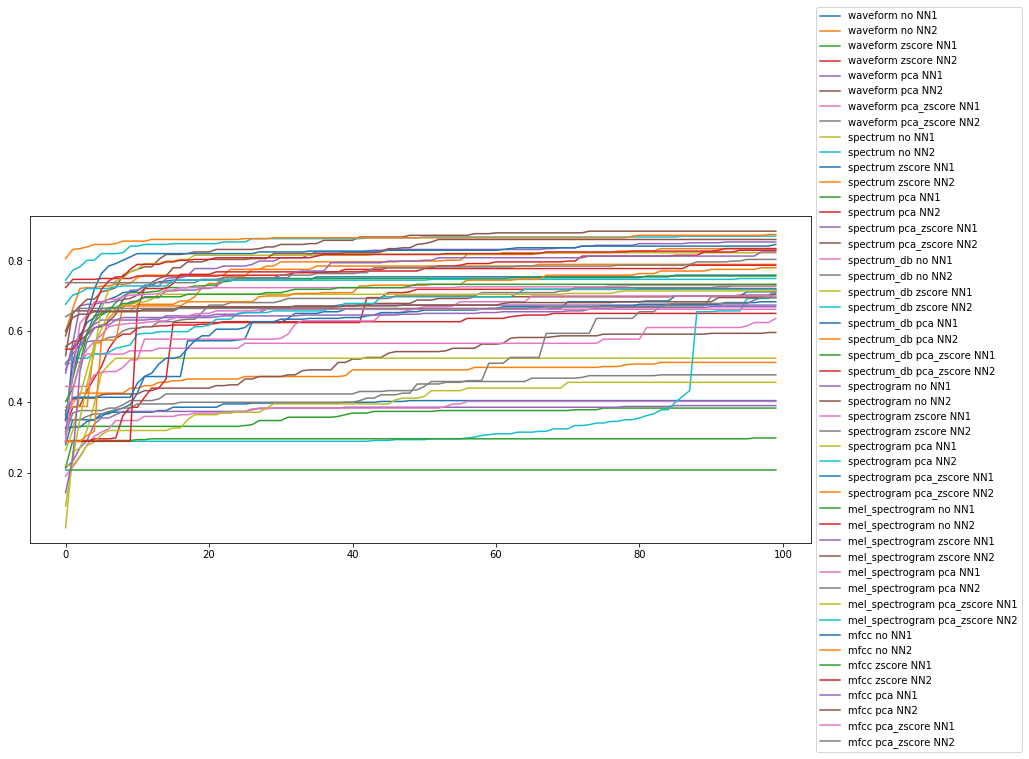

In [14]:
batch_size = 200
n_epochs = 100

df_ = []

figure(figsize=(14,6))

for i,(feature,prepro,classifier) in enumerate(itertools.product(*mega_list)):
    
    classifier_name = classifier.__name__
    prepro_name = prepro.__name__[4:]
    print('Features:',feature, ', Prepro:',prepro_name,', Classifier:',classifier_name)
    
    
    if 'pca' in prepro_name:
        
        X = load('pca_' + feature+'.npy')
        
    else:    

        X = load(feature+'.npy')

        if X.ndim>2:
            X = X.reshape(X.shape[0],-1)

    prepro()

    if X.min()<0:
        activation = tf.tanh
    else:
        activation = tf.sigmoid

    data = Data(X,y.values,test_size=0.2, stratify=df.category)
    print('Dataset shape ',data.X.shape)    
    
    out, elapsed_time = classifier()
 
    if out.size>1:
        score = max(out[:,0])
        plot(out[:,0],label=feature+' ' + prepro_name+' '+classifier_name)
    else:
        score = out
        
    print('\n')
  
    D = {'score':score,'time':elapsed_time,'classifier':classifier_name,'feature':feature,'prepro':prepro_name}
    
    df_.append(D)

legend(loc='center left', bbox_to_anchor=(1, 0.5))

df_scores = pd.DataFrame(df_)

In [25]:
from IPython.display import display
for prepro in prepro_list:
    prepro_name = prepro.__name__[4:]
    print(prepro_name)
    display(df_scores[df_scores.prepro==prepro_name].pivot('feature','classifier','score'))

no


classifier,NN1,NN2,RF
feature,,,
mel_spectrogram,0.20892,0.828638,0.7934272300469484
mfcc,0.683099,0.779343,0.636150234741784
spectrogram,0.852113,0.882629,0.7323943661971831
spectrum,0.523474,0.70892,0.7065727699530516
spectrum_db,0.63615,0.713615,0.7018779342723005
waveform,0.403756,0.511737,0.051643192488262914


zscore


classifier,NN1,NN2,RF
feature,,,
mel_spectrogram,0.823944,0.859155,0.7981220657276995
mfcc,0.732394,0.833333,0.6314553990610329
spectrogram,0.699531,0.7277,0.7323943661971831
spectrum,0.711268,0.788732,0.6971830985915493
spectrum_db,0.455399,0.71831,0.7253521126760564
waveform,0.382629,0.650235,0.0539906103286385


pca


classifier,NN1,NN2,RF
feature,,,
mel_spectrogram,0.732394,0.802817,0.6173708920187794
mfcc,0.669014,0.694836,0.5704225352112676
spectrogram,0.821596,0.868545,0.5704225352112676
spectrum,0.298122,0.720657,0.744131455399061
spectrum_db,0.758216,0.833333,0.352112676056338
waveform,0.389671,0.596244,0.24882629107981222


pca_zscore


classifier,NN1,NN2,RF
feature,,,
mel_spectrogram,0.713615,0.748826,0.6126760563380281
mfcc,0.661972,0.694836,0.5563380281690141
spectrogram,0.84507,0.873239,0.5774647887323944
spectrum,0.673709,0.704225,0.7582159624413145
spectrum_db,0.755869,0.786385,0.3380281690140845
waveform,0.401408,0.476526,0.24178403755868544


In [19]:
df_scores.to_pickle('scores.dataframe')